# Brownian Dynamics

In [1]:
from math import pi, sqrt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import random as rnd

In [2]:
def initial_configuration(num_of_particles, box_length, mean_distance):
    xi = []
    yi = []
    zi = []
    
    xi.append(0.5 * (mean_distance - box_length))
    yi.append(0.5 * (mean_distance - box_length))
    zi.append(0.5 * (mean_distance - box_length))
    
    for i in range(1, num_of_particles):
        x = xi[i - 1] + mean_distance
        y = yi[i - 1]
        z = zi[i - 1]
        
        if x > 0.5 * box_length:
            x = xi[0]
            y = yi[i - 1] + mean_distance
            
            if y > 0.5 * box_length:
                x = xi[0]
                y = yi[0]
                z = zi[i - 1] + mean_distance
            
        xi.append(x)
        yi.append(y)
        zi.append(z)
        
    return xi, yi, zi

In [3]:
def hard_sphere(r, rx, ry, rz, lr, la, a2, epi):
    if r < (lr / la)**(1.0 / (lr - la)):
        potential_energy = (a2 / epi) * ((1.0 / r)**lr - (1.0 / r)**la) + 1.0 / epi
        f = lr * (1.0 / r)**(lr + 1.0) - la * (1.0 / r)**(la + 1.0)
        f *= a2 / epi
    else:
        potential_energy = 0.0
        f = 0.0
    fx = f * rx / r
    fy = f * ry / r
    fz = f * rz / r
    
    return potential_energy, fx, fy, fz

In [4]:
def force(x, y, z, fx, fy, fz, box_length, cut_ratio, lr, la, a2, epi):
    num_of_particles = len(x)
    fx = np.zeros(num_of_particles)
    fy = np.zeros(num_of_particles)
    fz = np.zeros(num_of_particles)
    energy = 0.0
    
    for i in range(num_of_particles):
        for j in range(i + 1, num_of_particles):
            xij = x[i] - x[j]
            yij = y[i] - y[j]
            zij = z[i] - z[j]
            xij -= box_length * round(xij / box_length)
            yij -= box_length * round(yij / box_length)
            zij -= box_length * round(zij / box_length)
            rij2 = xij**2 + yij**2 + zij**2
            rij = sqrt(rij2)
            
            if rij < cut_ratio:
                uij, fxij, fyij, fzij = hard_sphere(rij, xij, yij, zij, lr, la, a2, epi)
                energy += uij
                fx[i] += fxij
                fy[i] += fyij
                fz[i] += fzij
                fx[j] -= fxij
                fy[j] -= fyij
                fz[j] -= fzij
                
    return energy, fx, fy, fz

In [5]:
def position(num_of_particles, box_length, x, y, z, fx, fy, fz, delta_t, pbc, my_seed):
    std_dev = 1.0
    mean = 0.0
    sigma = sqrt(2.0 * delta_t)
    rnd.seed(my_seed)
    
    for i in range(num_of_particles):
        dx = sigma * rnd.gauss(std_dev, mean)
        dy = sigma * rnd.gauss(std_dev, mean)
        dz = sigma * rnd.gauss(std_dev, mean)
        x[i] += dx + fx[i] * delta_t
        y[i] += dy + fy[i] * delta_t
        z[i] += dz + fz[i] * delta_t
        
        if pbc > 0.0:
            x[i] -= box_length * round(x[i] / box_length)
            y[i] -= box_length * round(y[i] / box_length)
            z[i] -= box_length * round(z[i] / box_length)
            
    return x, y, z

In [26]:
def gr(x, y, z, g, dr, num_of_particles, r_partition, boxl, rc):
    for i in range(num_of_particles):
        for j in range(i  +  1, num_of_particles):
            xij = x[j] - x[i]
            yij = y[j] - y[i]
            zij = z[j] - z[i]
            xij = xij - boxl * round(xij / boxl)
            yij = yij - boxl * round(yij / boxl)
            zij = zij - boxl * round(zij / boxl)
            rij2 = xij * xij + yij * yij + zij * zij
            rij = sqrt(rij2)
            
            if rij < rc:
                nbin = int(rij / dr) + 1
                if nbin <= r_partition:
                    g[nbin] += 2.0

In [17]:
num_of_particles = 3**3 # Must be a cube
packing_fraction = 0.5
l_repulsive = 50.0
l_attractive = 49.0
epi = 1.4737
pbc = 1.0 # Periodic boundary condition
delta_t = 0.00001
therm_time = 200000
iseed = 1234567890
diameter = 6.0 * packing_fraction / pi
mean_distance = diameter**(-1.0 / 3.0)
box_length = (num_of_particles / diameter)**(1.0 / 3.0)
a2 = (l_repulsive / (l_repulsive - l_attractive)) * \
     (l_repulsive / l_attractive)**(l_attractive / (l_repulsive - l_attractive))
cut_ratio = 0.5 * box_length

In [18]:
time_window = 100000
r_partition = 2**8
dr = cut_ratio / r_partition

# ????
ncep = 10
ncp = 1000000
nprom = 0
nconf = ncp

In [20]:
r = np.zeros(r_partition)
g = np.zeros(r_partition) # radial distribution function
q = np.zeros(r_partition) # wave vector
sq = np.zeros(r_partition) # structure factor
h = np.zeros(r_partition) # Fourier transform of g - 1

t = np.zeros(time_window)
wt = np.zeros(time_window) # mean squared displacement
ft = np.zeros(time_window) # Función de distribución intermedia auto

# Coordenadas i-ésima partícula al tiempo t
cfx = np.zeros((time_window, num_of_particles))
cfy = np.zeros((time_window, num_of_particles))
cfz = np.zeros((time_window, num_of_particles))

In [9]:
x, y, z = initial_configuration(num_of_particles, box_length, mean_distance)

x_force = np.zeros(num_of_particles)
y_force = np.zeros(num_of_particles)
z_force = np.zeros(num_of_particles)

In [10]:
energy, x_force, y_force, z_force = force(x, y, z, x_force, y_force, z_force, \\
                                          box_length, cut_ratio, l_repulsive, l_attractive, a2, epi)

In [11]:
print("initial energy:", energy / num_of_particles)

initial energy: 0.06834096389861033


Text(0.5, 0, 'Z')

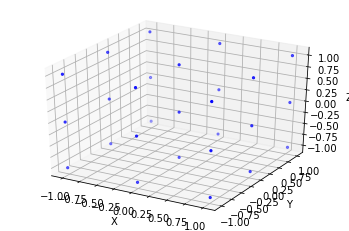

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c = 'b', marker = '.') 
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

In [13]:
for T in range(therm_time):
    x, y, z = position(num_of_particles, box_length, x, y, z, x_force, y_force, z_force, delta_t, pbc, iseed)
    energy, x_force, y_force, z_force = force(x, y, z, box_length, cut_ratio, l_repulsive, l_attractive, a2, epi)
    epotn = energy / num_of_particles
    if T%1000 == 0:
        print(T, epotn, 'Thermalization')

0 0.06834096389861033 Thermalization
1000 0.06834096389861534 Thermalization
2000 0.06834096389861025 Thermalization
3000 0.06834096389862042 Thermalization
4000 0.06834096389861025 Thermalization
5000 0.06834096389860522 Thermalization
6000 0.0683409638986153 Thermalization
7000 0.0683409638986103 Thermalization
8000 0.0683409638986153 Thermalization
9000 0.0683409638986103 Thermalization
10000 0.06834096389862046 Thermalization
11000 0.06834096389861537 Thermalization
12000 0.06834096389861025 Thermalization
13000 0.06834096389861537 Thermalization
14000 0.06834096389861025 Thermalization
15000 0.06834096389861537 Thermalization
16000 0.06834096389861534 Thermalization
17000 0.06834096389861025 Thermalization
18000 0.06834096389861534 Thermalization
19000 0.06834096389861025 Thermalization
20000 0.06834096389861534 Thermalization
21000 0.0683409638986153 Thermalization
22000 0.0683409638986103 Thermalization
23000 0.0683409638986153 Thermalization
24000 0.0683409638986103 Thermalizat

In [27]:
pbc = 0.0

for i in range(nconf):
    x, y, z = position(num_of_particles, box_length, x, y, z, x_force, y_force, z_force, delta_t, pbc, iseed)
    energy, x_force, y_force, z_force = force(x, y, z, box_length, cut_ratio, l_repulsive, l_attractive, a2, epi)
    epotn = energy / num_of_particles
    if i%10000 == 0:
        print(i, epotn / num_of_particles, 'Average')
    if i%ncep == 0:
        nprom += 1
        t[nprom] = delta_t * ncep * (nprom - 1)
        for j in range(num_of_particles):
            cfx[nprom][j] = x[j]
            cfy[nprom][j] = y[j]
            cfz[nprom][j] = z[j]
        gr(x, y, z, g, dr, num_of_particles, r_partition, box_length, cut_ratio)

0 0.002531146811059822 Average
10000 0.002531146811059822 Average


KeyboardInterrupt: 